BB84_protocol
====================
This notebook demonstrates how to compute the finite-length key rate for the standard BB84 protocol using convex optimization.

The calculation done in this notebook shows how we do postselection in the calculation

Author: Darius Bunandar (dariusb@mit.edu)

Unauthorized use and/or duplication of this material without express and
written permission from the author and/or owner is strictly prohibited.

In [1]:
# Initialization Cell
import matlab.engine
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import numerical_qkd as nQKD
import itertools
from tqdm import tqdm_notebook as tqdm

MATLAB_LIB_LOC = os.path.join(
    '..', 'numerical_qkd', 'matlab_lib')  # change as necessary


matlab_eng = matlab.engine.start_matlab()
matlab_eng.addpath(MATLAB_LIB_LOC, nargout=0)

# Some helpful definitions
ket_0 = np.array([1., 0.])
ket_1 = np.array([0., 1.])
ket_p = np.array([1., 1.])/np.sqrt(2)
ket_m = np.array([1., -1.])/np.sqrt(2)
sigma_00 = np.outer(ket_0, np.conj(ket_0))
sigma_11 = np.outer(ket_1, np.conj(ket_1))
sigma_pp = np.outer(ket_p, np.conj(ket_p))
sigma_mm = np.outer(ket_m, np.conj(ket_m))

EngineError: Unable to launch MVM server: License Error

## Asymptotic secret key rate

In [2]:
"""
Problem definition
"""
dim = 2
dims = [dim, dim]

Z0 = sigma_00
Z1 = sigma_11
key_map_povm = [Z0, Z1]

postselect_prob = np.array([.25, .25])  # assume they choose pz=px=1/2
Ez = np.kron(sigma_00, sigma_11) + np.kron(sigma_11, sigma_00)
Ex = np.kron(sigma_pp, sigma_mm) + np.kron(sigma_mm, sigma_pp)
Gamma = [Ez, Ex]
Gamma = [G*p for G, p in zip(Gamma, postselect_prob)]

In [3]:
# Numerical method
qber = np.linspace(0, .12, 21)
key_opt_primal_asymptotic = np.empty_like(qber)

p_pass = np.sum(postselect_prob)

H = nQKD.RelativeEntropyKeyrate(key_map_povm, [dim, dim])

for i, q in tqdm(enumerate(qber)):
    gamma = np.array([q, q]) * postselect_prob
    ex_const = {'Gamma': Gamma, 'gamma': gamma}
    H.set_constraints(exact_constraints=ex_const)
    key_opt_primal_asymptotic[i] = H.compute_primal_with_matlab(matlab_eng)
        # This computes the key per successful detection
    
hq = np.array([nQKD.bin_entropy(q) for q in qber])
key_asymptotic = p_pass*(key_opt_primal_asymptotic - hq)

In [4]:
# Analytical method
qber_analytic = np.linspace(0, .2, 1001)
p_pass = np.sum(postselect_prob)
key_analytic_asymptotic = np.array([1-2*nQKD.bin_entropy(q) for q in qber_analytic])
key_analytic_asymptotic *= p_pass

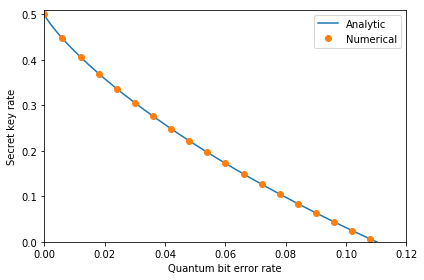

In [6]:
# Plot results
%matplotlib inline

plt.plot(qber_analytic, key_analytic_asymptotic, '-', label='Analytic')
plt.plot(qber, key_asymptotic, 'o', label='Numerical')
plt.ylim([0,.51])
plt.xlim([-1e-4,.12])
plt.xlabel('Quantum bit error rate')
plt.ylabel('Secret key rate')
plt.legend()
plt.tight_layout()
plt.savefig('bb84_asymptotic.eps', format='eps', dpi=1000, transparent=True)
plt.show()

## Secret key rate from solving $H_{\min}(Z_A|E)$
Analyze how many transmissions are needed to obtain a non-zero key-rate in the entanglement-based scenario.

We compare the numerical results with the analytical results.

$\ell \leq n \left[ H_{\min}(Z|E) - \text{leak}_{EC} \right] - 2 \log_2 (1/2 \varepsilon_{PA}) - \log_2 (2/\varepsilon_{cor})$

Analytically, 

$H_{\min}(Z|E) = -\log_2 \left[ \frac{1}{2} \left(1+2\sqrt{(1-Q)Q} \right) \right]$.

In [15]:
"""
Problem definition
"""
dim = 2
dims = [dim, dim]

Z0 = sigma_00
Z1 = sigma_11
key_map_povm = [Z0, Z1]

postselect_prob = np.array([.25, .25])  # assume they choose pz=px=1/2
Ez = np.kron(sigma_00, sigma_11) + np.kron(sigma_11, sigma_00)
Ex = np.kron(sigma_pp, sigma_mm) + np.kron(sigma_mm, sigma_pp)
Gamma = [Ez, Ex]
Gamma = [G*p for G, p in zip(Gamma, postselect_prob)]

channel_eff = 1
ratio_PE = .1  # ratio of successful detections for parameter estimation

# Epsilon errors
eps_sec = 1e-5 # coherent attack
eps_cor = 1e-15
nPE = 2
# eps_sec = eps + eps_PE + eps_PA + eps_EC

In [16]:
# Numerical calculations
total_signals_sent = np.logspace(5, 13, 21)
qber = np.linspace(0, .1, 5)

# Total probability of failure in parameter estimation
eps_PE_total = np.empty([len(qber), len(total_signals_sent)])

# l_primal and l_dual are the key rate per successful detection
# obtained by solving the primal and dual methods respectively.
l_dual = np.empty([len(qber), len(total_signals_sent)])

HoeffdingBound = nQKD.HoeffdingInequality()

qkd = nQKD.RelativeMinEntropyKeyrate(key_map_povm, dims)

for j, q in tqdm(enumerate(qber), leave=False):
    gamma = np.array([q, q]) * postselect_prob
    basis_info_list = nQKD.BasisInformationList([nQKD.BasisInformation(
        Gamma=G, gamma=g, probability=p)
        for G, g, p in zip(Gamma, gamma, postselect_prob)])

    for i, n_signals in tqdm(enumerate(total_signals_sent), leave=False):

        eps_coll = eps_sec * np.power(float(n_signals+1), -(dim**4-1))
        error = eps_coll / (nPE + 2)
        eps_PE = error  # for each parameter
        eps_PA = error
        eps_EC = error 
        
        # Parameter estimation
        HoeffdingBound.reset_counters()
        basis_info_list = nQKD.Constraints.single_photon_constraint_bounds(
            basis_info_list, ratio_PE*n_signals, eps_PE,
            HoeffdingBound, nQKD.simulate_single_photons, bob_eff=channel_eff)
        eps_PE_total[j, i] = HoeffdingBound.upper_bound_failure_prob

        # Compute keyrate
        gamma_lb = basis_info_list.unpack('gamma_lb')
        gamma_ub = basis_info_list.unpack('gamma_ub')
        inexact_const = {'Gamma': Gamma,
                         'gamma_lb': gamma_lb, 'gamma_ub': gamma_ub}
        qkd.set_constraints(inexact_constraints=inexact_const)
        l_dual[j, i] = qkd.compute_dual(solver='MOSEK')

p_pass = np.sum(postselect_prob)
prob_detection = nQKD.simulate_single_photons(channel_eff)*p_pass
n = prob_detection*(1-ratio_PE)*total_signals_sent
hq = np.array([nQKD.bin_entropy(q) for q in qber])
post_processing = n*hq[:, np.newaxis] + 2 * \
    np.log2(.5/eps_PA) + np.log2(2/eps_cor) + \
    n*np.log2(5)*np.sqrt(3*np.log2(2/eps_EC)/n)

l_dual = n*l_dual - post_processing
l_dual[l_dual < 0] = 0

r_dual_coll = l_dual/total_signals_sent
coh_correction = 2*(dim**4-1)*np.log2(total_signals_sent+1)/total_signals_sent
r_dual = r_dual_coll - coh_correction

In [17]:
# Analytical calculations
analytic_total_signals_sent = np.logspace(3, 13, 1001)
analytic_qber_max = np.empty([len(qber), len(analytic_total_signals_sent)])
l_analytic = np.empty_like(analytic_qber_max)

for j, q in enumerate(qber):
    gamma = np.array([q, q]) * postselect_prob
    basis_info_list = nQKD.BasisInformationList([nQKD.BasisInformation(
        Gamma=G, gamma=g, probability=p)
        for G, g, p in zip(Gamma, gamma, postselect_prob)])
    
    for i, n_signals in enumerate(analytic_total_signals_sent):
        
        eps_coll = eps_sec * np.power(float(n_signals+1), -(dim**4-1))
        error = eps_coll / (nPE + 2)
        eps_PE = error  # for each parameter
        eps_PA = error
        eps_EC = error
        
        # Parameter estimation
        HoeffdingBound.reset_counters()
        basis_info_list = nQKD.Constraints.single_photon_constraint_bounds(
            basis_info_list, ratio_PE*n_signals, eps_PE,
            HoeffdingBound, nQKD.simulate_single_photons, bob_eff=channel_eff)

        gamma_ub = basis_info_list.unpack('gamma_ub')
        gamma_ub /= postselect_prob
        
        # QBER should be the same in both bases if pz_A = pz_B = 1/2
        assert(np.isclose(gamma_ub[0], gamma_ub[1])), "QBER unequal"
        
        # take the maximum QBER as the worst case scenario
        q_ = gamma_ub[0] if gamma_ub[0]<0.5 else 0.5
        analytic_qber_max[j,i] = q_
        l_analytic[j,i] = -1*np.log2(.5*(1+2*np.sqrt(q_*(1-q_))))

p_pass = np.sum(postselect_prob)
prob_detection = nQKD.simulate_single_photons(channel_eff)*p_pass
n = prob_detection*(1-ratio_PE)*analytic_total_signals_sent
hq = np.array([nQKD.bin_entropy(q) for q in qber])
post_processing = n*hq[:, np.newaxis] + 2 * \
    np.log2(.5/eps_PA) + np.log2(2/eps_cor) + \
    n*np.log2(5)*np.sqrt(3*np.log2(2/eps_EC)/n)

l_analytic = n*l_analytic - post_processing
l_analytic[l_analytic < 0] = 0

r_analytic = l_analytic / analytic_total_signals_sent
coh_correction = 2*(dim**4-1)*np.log2(analytic_total_signals_sent+1)/analytic_total_signals_sent
r_analytic = r_analytic - coh_correction

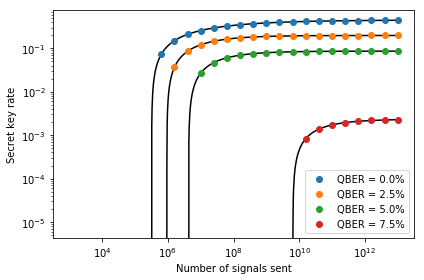

In [18]:
output_figure = False

if output_figure:
    %matplotlib inline
#     np.savez('bb84_min_entropy.npz', total_signals_sent, qber, r_primal, r_dual)
    np.savez('bb84_min_entropy.npz', total_signals_sent, qber, r_dual)
else:
    %matplotlib inline

# Plot data
color_wheel = ['C0', 'C1', 'C2', 'C3']
for i, q in enumerate(qber[:-1]):
    q_ = "{:.1f}".format(q*100)
    label_name = "QBER = "+q_+"%"
    col = color_wheel[i]
    plt.loglog(analytic_total_signals_sent,
               r_analytic[i, :], '-', color='k')
    plt.loglog(total_signals_sent,
               r_dual[i, :], 'o', label=label_name, color=col)
plt.xlabel('Number of signals sent')
plt.ylabel('Secret key rate')
plt.legend()
plt.tight_layout()

if output_figure:
    plt.savefig('bb84_min_entropy.eps', format='eps',
                dpi=1000, transparent=True)
plt.show()